# Group 6 Assignment Python

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, time, datetime
import matplotlib.font_manager
from sqlalchemy import create_engine
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from collections import Counter

import os
import sys
import re
import time
import datetime

### Loading Data

In [ ]:
# loading csv file as DataFrame
df = pd.read_csv('pizza_sales.csv')
df.head()

### EDA

In the EDA for the Pizza shop we will analyze the following things:
* peaks in order time
* seasonal trends in order time (time of the day, day of the week, across months)
* average order value
* average order quantity
* most popular pizza
* most popular pizza category
* most popular pizza size
* average order price per hour

For this EDA some modifications will be made to the initial features, and some features will be added

#### Multi-label Binarization of pizza_ingredients

We will binarize the pizza ingredients to reduce the complexity of the list and have an overview of the ingredients that the shop uses. .

In [ ]:
# converting the date column to datetime
df['order_date'] = pd.to_datetime(df['order_date'])
df['order_time'] = pd.to_datetime(df['order_time'])

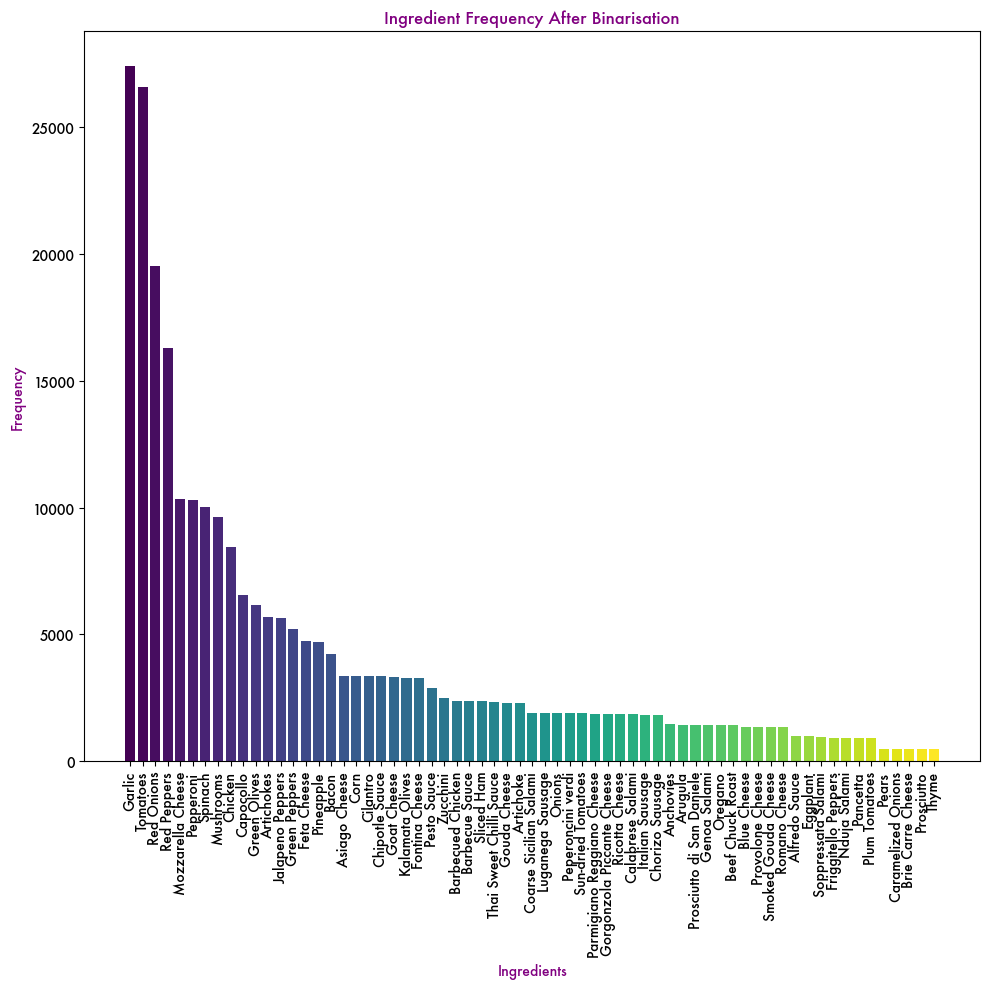

In [105]:
# Correcting spelling in ingredients
df['pizza_ingredients'] = df['pizza_ingredients'].str.replace('慛duja Salami', 'Nduja Salami')

# Splitting each string by commas and and create new feature 'all_ingredients'
all_ingredients = [ingredient.strip() for sublist in df['pizza_ingredients'] for ingredient in sublist.split(',')]

# Showing all unique ingredients
unique_ingredients = set(all_ingredients)
print("Unique ingredients:\n", unique_ingredients)

# Counting the number of unique ingredients
num_unique_ingredients = len(unique_ingredients)
print("Number of unique ingredients:", num_unique_ingredients)

# Counting how many times each ingredient is used
ingredient_usage = Counter(all_ingredients)
print("Ingredient usage:\n", ingredient_usage)

# Creating lists of strings for the ingredients
# Converting 'pizza_ingredients' from comma-separated strings to lists of ingredients
df['ingredient_list'] = df['pizza_ingredients'].apply(lambda x: [ingredient.strip() for ingredient in x.split(',')])

# Initializing the MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fitting and transforming the 'ingredient_list' column to get a binary matrix
binary_matrix = mlb.fit_transform(df['ingredient_list'])

# Transforming the ingredients list into a datatype that can be supported to load it to the database (lists are not accepted)
if 'ingredient_list' in df.columns:
    df['ingredient_list'] = df['ingredient_list'].apply(lambda x: ','.join(x) if isinstance(x, list) else x)

# Creating a DataFrame from the binary matrix
ingredients_df = pd.DataFrame(binary_matrix, columns=mlb.classes_)

# Setting font for plot
plt.rcParams['font.family'] = 'Futura'

# Plotting the histogram of ingredient frequencies
# Summing up the occurrences of each ingredient across all pizzas
ingredient_counts = ingredients_df.sum().sort_values(ascending=False)

cmap = plt.get_cmap("viridis")
colors = cmap(np.linspace(0, 1, len(ingredient_counts)))

plt.figure(figsize=(10, 10))

# Applying the viridis colors to each bar
plt.bar(ingredient_counts.index, ingredient_counts.values, color=colors)
plt.xlabel('Ingredients', fontsize=10, color="purple")
plt.ylabel('Frequency', fontsize=10, color="purple")
plt.title('Ingredient Frequency After Binarization', color="purple")
plt.xticks(rotation=90)
plt.tight_layout()  # Adjusting layout
plt.show()

In [107]:
# Concatenating both DataFrames
df_combined = pd.concat([df, ingredients_df], axis=1)

# checking the unique values in each of the categorical columns
df_combined[['pizza_size', 'pizza_category','pizza_ingredients','pizza_name']].apply(lambda x: x.unique())
df_combined[['pizza_name']].apply(lambda x: x.unique())

# removing the Pizza from the pizza_name column
df_combined['pizza_name'] = df_combined['pizza_name'].str.replace('Pizza', '')

pizza_size                                          [M, L, S, XL, XXL]
pizza_category                     [Classic, Veggie, Supreme, Chicken]
pizza_ingredients    [Sliced Ham, Pineapple, Mozzarella Cheese, Pep...
pizza_name           [The Hawaiian Pizza, The Classic Deluxe Pizza,...
dtype: object
                                    pizza_name
0                           The Hawaiian Pizza
1                     The Classic Deluxe Pizza
2                        The Five Cheese Pizza
3                    The Italian Supreme Pizza
4                           The Mexicana Pizza
5                       The Thai Chicken Pizza
6             The Prosciutto and Arugula Pizza
7                   The Barbecue Chicken Pizza
8                              The Greek Pizza
9                    The Spinach Supreme Pizza
10                      The Green Garden Pizza
11                 The Italian Capocollo Pizza
12                     The Spicy Italian Pizza
13                     The Spinach Pesto Piz

#### Reducing time intervals

The order time will be reduced to every half an hour for the sake of simplicity with a UDF
- Orders placed between 11:00 and 11:29 will be binned as 11:00.
- Orders placed between 11:30 and 11:59 will be binned as 11:30. 

In [108]:
# Creating UDF to bin hour
def to_half_hour(dt):
    if dt.minute < 30:
        return dt.replace(minute=0, second=0)
    else:
        return dt.replace(minute=30, second=0)

# Applying the function to create a new 'half_hour_bin' column
df_combined['half_hour_bin'] = df_combined['order_time'].apply(to_half_hour)

df_combined['half_hour_bin'].head()

0       2024-03-20 11:30:00
1       2024-03-20 11:30:00
2       2024-03-20 11:30:00
3       2024-03-20 11:30:00
4       2024-03-20 11:30:00
5       2024-03-20 11:30:00
6       2024-03-20 12:00:00
7       2024-03-20 12:00:00
8       2024-03-20 12:00:00
9       2024-03-20 12:00:00
10      2024-03-20 12:00:00
11      2024-03-20 12:00:00
12      2024-03-20 12:30:00
13      2024-03-20 12:30:00
14      2024-03-20 12:30:00
15      2024-03-20 12:30:00
16      2024-03-20 12:30:00
17      2024-03-20 12:30:00
18      2024-03-20 12:30:00
19      2024-03-20 12:30:00
20      2024-03-20 12:30:00
21      2024-03-20 12:30:00
22      2024-03-20 12:30:00
23      2024-03-20 13:00:00
24      2024-03-20 13:00:00
25      2024-03-20 13:00:00
26      2024-03-20 13:00:00
27      2024-03-20 13:00:00
28      2024-03-20 13:00:00
29      2024-03-20 13:00:00
30      2024-03-20 13:00:00
31      2024-03-20 13:00:00
32      2024-03-20 13:00:00
33      2024-03-20 13:00:00
34      2024-03-20 13:00:00
35      2024-03-20 1

#### Orders per half-hour interval

/var/folders/m5/kn9mxdbn7nx7cjrgtfwsk1700000gn/T/ipykernel_50358/2655431102.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_combined_sorted, x="half_hour_bin_str", palette="plasma")


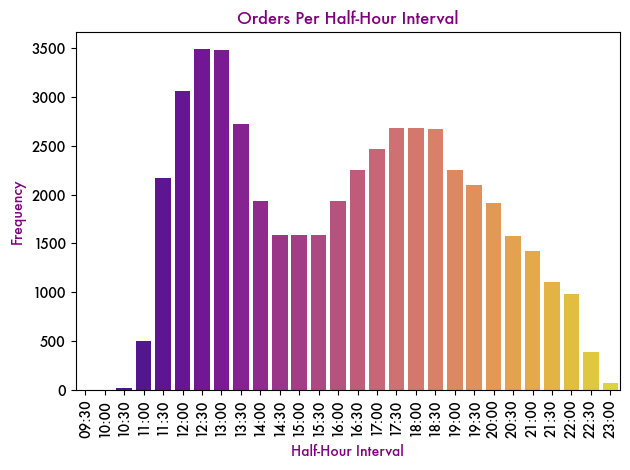

In [111]:
# Converting 'half_hour_bin' to string format displaying only hours and minutes
df_combined['half_hour_bin_str'] = df_combined['half_hour_bin'].dt.strftime('%H:%M')

# Sorting the DataFrame by 'half_hour_bin' to ensure chronological order
df_combined_sorted = df_combined.sort_values(by='half_hour_bin')

# Setting the font for the plot
plt.rcParams['font.family'] = 'Futura'

# Plotting using the sorted DataFrame
sns.countplot(data=df_combined_sorted, x="half_hour_bin_str", palette="plasma")
plt.xticks(rotation=90)
plt.xlabel("Half-Hour Interval", fontsize=10, color="purple")
plt.ylabel("Frequency", fontsize=10, color="purple")
plt.title("Orders Per Half-Hour Interval", color="purple")
plt.tight_layout()
plt.show()


#### Orders per Weekday

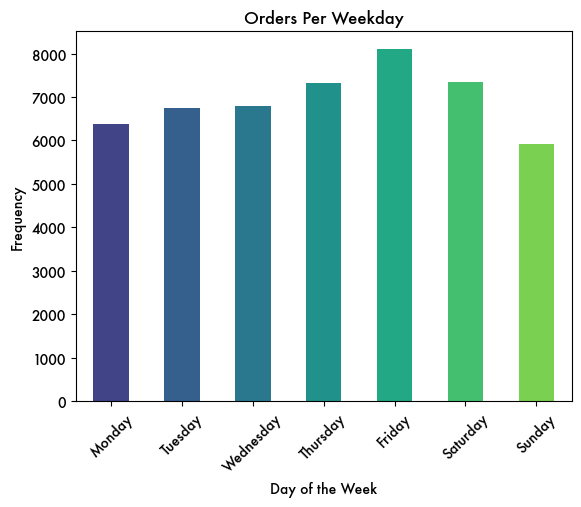

order_dates
Monday       6369
Tuesday      6753
Wednesday    6797
Thursday     7323
Friday       8106
Saturday     7355
Sunday       5917
Name: count, dtype: int64


In [112]:
# Creating a column with the day names
df['order_dates'] = df['order_date'].dt.day_name()

# Defining the correct order for the days of the week
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.rcParams['font.family'] = 'Futura'

# Using value_counts but reindex to ensure the days are in order, then plot
df['order_dates'].value_counts().reindex(weekday_order).plot(kind='bar', color=plt.get_cmap('viridis')(np.linspace(0.2, 0.8, len(weekday_order))))
plt.xlabel('Day of the Week', fontsize=10, color="black")
plt.ylabel('Frequency', fontsize=10, color="black")
plt.title('Orders Per Weekday', color="black")
plt.xticks(rotation=45)
plt.show()

# print counts of pizza orders per weekday
print(df['order_dates'].value_counts().reindex(weekday_order))

#### Orders per Month

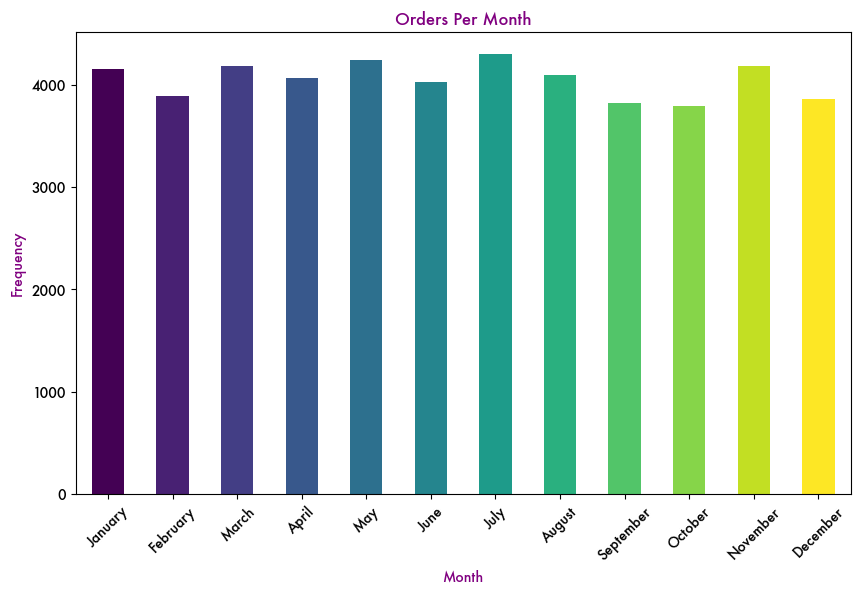

In [89]:
plt.rcParams['font.family'] = 'Futura'

# Creating a column with month names directly
df_combined['order_month'] = df_combined['order_date'].dt.month_name()

# Ensuring the order of months when plotting
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
order_month_counts = df_combined['order_month'].value_counts().reindex(month_order)

# Creating plot
plt.figure(figsize=(10, 6))
order_month_counts.plot(kind='bar', color=plt.get_cmap('viridis')(np.linspace(0, 1, len(month_order))))
plt.xlabel('Month', fontsize=10, color="purple")
plt.ylabel('Frequency', fontsize=10, color="purple")
plt.title('Orders Per Month', color="purple")
plt.xticks(rotation=45)
plt.show()


#### Pizza ID ordered by sales

/var/folders/m5/kn9mxdbn7nx7cjrgtfwsk1700000gn/T/ipykernel_50358/2137419580.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='pizza_id', y='counts', data=pizza_counts, palette=colors, ax=ax)
/var/folders/m5/kn9mxdbn7nx7cjrgtfwsk1700000gn/T/ipykernel_50358/2137419580.py:15: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x='pizza_id', y='counts', data=pizza_counts, palette=colors, ax=ax)


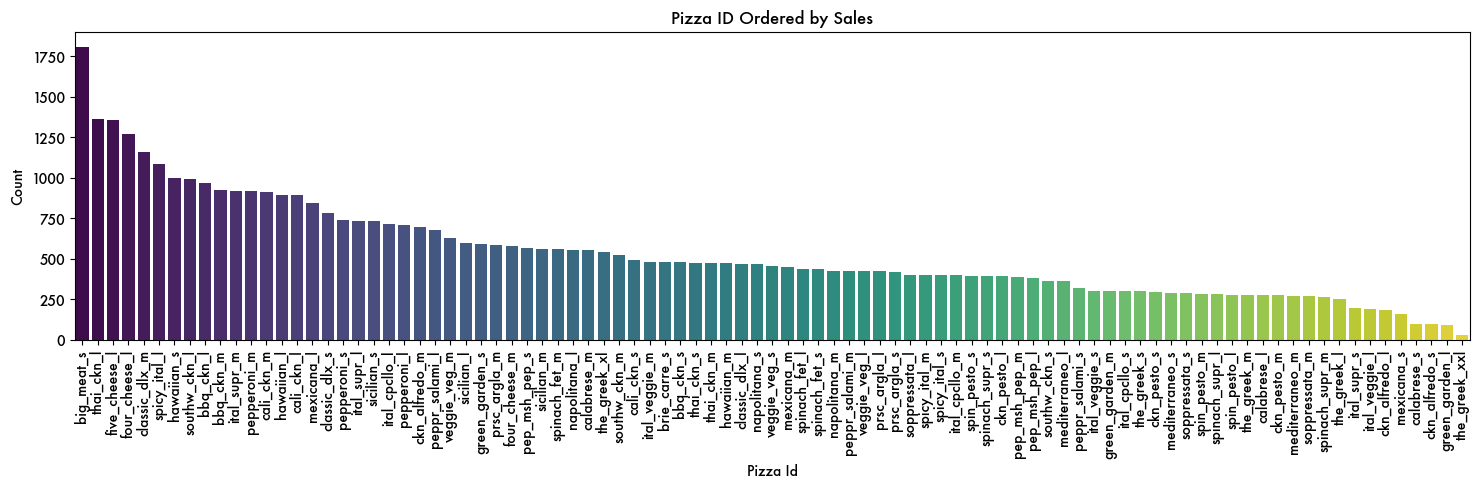

          pizza_id  counts
0       big_meat_s    1811
1       thai_ckn_l    1365
2    five_cheese_l    1359
3    four_cheese_l    1273
4    classic_dlx_m    1159
..             ...     ...
86      mexicana_s     160
87     calabrese_s      99
88   ckn_alfredo_s      96
89  green_garden_l      94
90   the_greek_xxl      28

[91 rows x 2 columns]


In [21]:
# Counting the values per pizza id
pizza_counts = df_combined['pizza_id'].value_counts().reset_index()
pizza_counts.columns = ['pizza_id', 'counts']

# Sorting the pizzas from most to least popular
pizza_counts = pizza_counts.sort_values('counts', ascending=False)

# Creating the plot
fig, ax = plt.subplots(figsize=(18, 4))
colors = plt.get_cmap('viridis')(np.linspace(0, 1, len(pizza_counts)))
sns.barplot(x='pizza_id', y='counts', data=pizza_counts, palette=colors, ax=ax)
plt.rcParams['font.family'] = 'Futura'
plt.xticks(rotation=90)
plt.xlabel("Pizza Id", fontsize=10, color="black")
plt.ylabel("Count", fontsize=10, color="black")
plt.title("Pizza ID Ordered by Sales", color="black")
plt.show()

#### Order Frequency

quantity
1    47693
2      903
3       21
4        3
Name: count, dtype: int64


/var/folders/m5/kn9mxdbn7nx7cjrgtfwsk1700000gn/T/ipykernel_50358/2891411103.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_combined, x="quantity", palette="viridis")


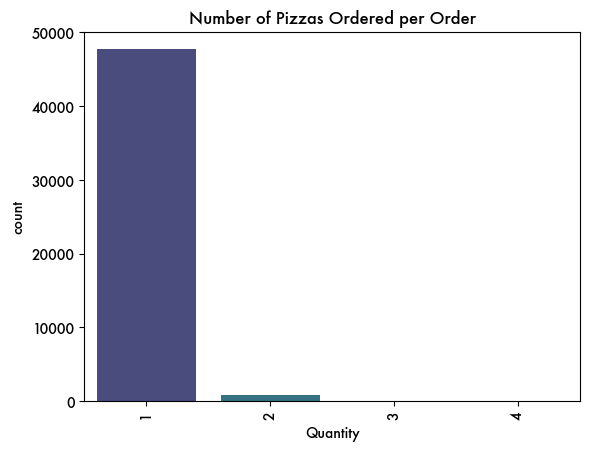

In [22]:
# looking at the number of pizzas ordered per order
print(df_combined.quantity.value_counts())

# Plotting
plt.rcParams['font.family'] = 'Futura'
sns.countplot(data=df_combined, x="quantity", palette="viridis")
plt.xticks(rotation=90)
plt.xlabel("Quantity", fontsize=10, color="black")
plt.title("Number of Pizzas Ordered per Order", color="black")
plt.show()


#### Orders with 2-4 Pizzas
We will check for seasonal trends in orders composed of 2 to 4 pizzas

/var/folders/m5/kn9mxdbn7nx7cjrgtfwsk1700000gn/T/ipykernel_50358/1735458987.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2_3_4['order_hour'] = df_2_3_4['order_time'].dt.hour
/var/folders/m5/kn9mxdbn7nx7cjrgtfwsk1700000gn/T/ipykernel_50358/1735458987.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2_3_4['order_hour'] = df_2_3_4['order_time'].dt.hour
/var/folders/m5/kn9mxdbn7nx7cjrgtfwsk1700000gn/T/ipykernel_50358/1735458987.py:10: SettingWithCopyWarning: 
A value is trying to be set on a cop

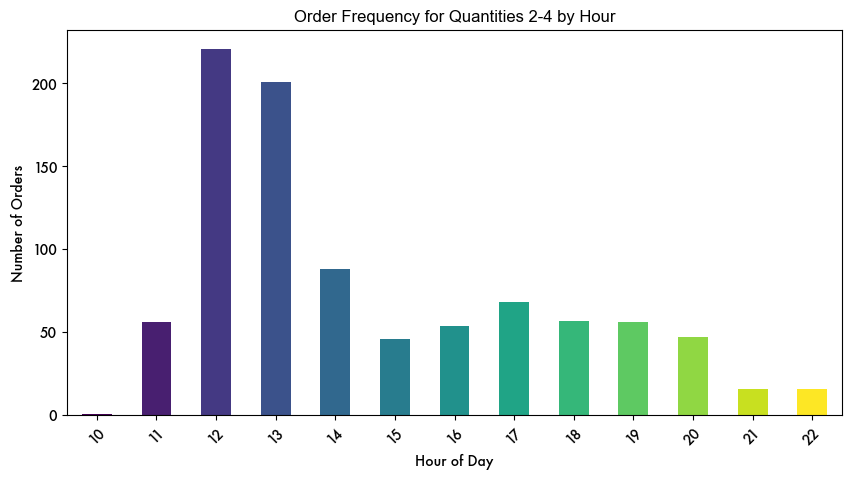

/var/folders/m5/kn9mxdbn7nx7cjrgtfwsk1700000gn/T/ipykernel_50358/1735458987.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2_3_4['order_day'] = df_2_3_4['order_date'].dt.day_name()


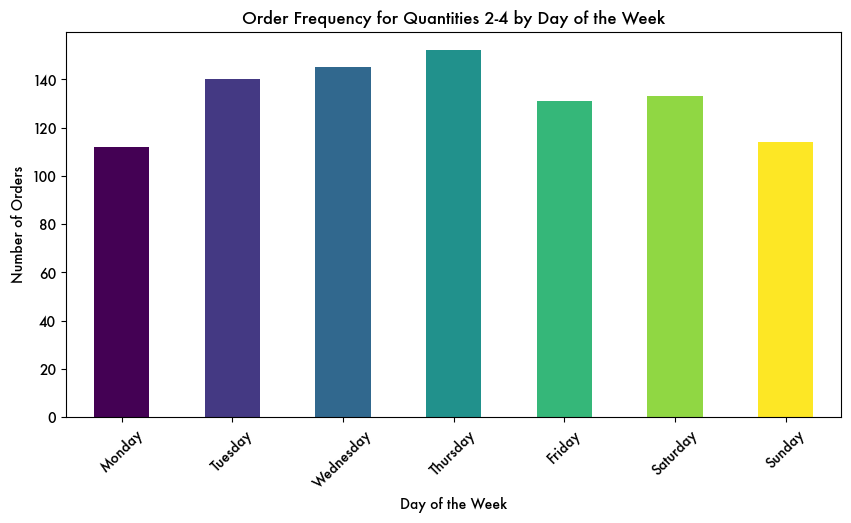

/var/folders/m5/kn9mxdbn7nx7cjrgtfwsk1700000gn/T/ipykernel_50358/1735458987.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2_3_4['order_month'] = df_2_3_4['order_date'].dt.month_name()


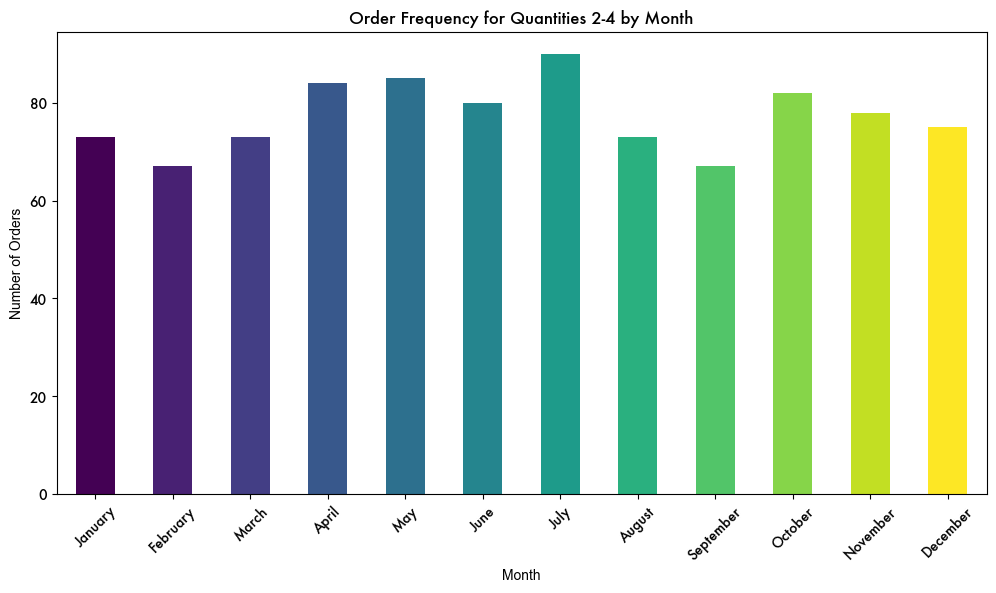

In [24]:
# Create a DataFrame with only orders of quantity 2, 3, and 4
df_2_3_4 = df_combined[df_combined['quantity'].isin([2, 3, 4])]

df_2_3_4['order_hour'] = df_2_3_4['order_time'].dt.hour
hourly_distribution = df_2_3_4['order_hour'].value_counts().sort_index()

df_2_3_4['order_hour'] = df_2_3_4['order_time'].dt.hour
hourly_distribution = df_2_3_4['order_hour'].value_counts().sort_index()

# Hourly Distribution
df_2_3_4['order_hour'] = df_2_3_4['order_time'].dt.hour
hourly_distribution = df_2_3_4['order_hour'].value_counts().sort_index()

# plotting by hour distribution
colors = plt.cm.viridis(np.linspace(0, 1, hourly_distribution.size))
plt.rcParams['font.family'] = 'Futura'
plt.figure(figsize=(10, 5))
hourly_distribution.plot(kind='bar', color=colors)
plt.title('Order Frequency for Quantities 2-4 by Hour', fontname='Arial')  # Change fontname as per availability
plt.xlabel('Hour of Day', fontname='Futura')
plt.ylabel('Number of Orders', fontname='Futura')
plt.xticks(rotation=45)
plt.show()

# Day of the week distribution
df_2_3_4['order_day'] = df_2_3_4['order_date'].dt.day_name()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_distribution = df_2_3_4['order_day'].value_counts().reindex(days_order)

# Plotting by day of the week distribution
plt.figure(figsize=(10, 5))
colors_day = plt.cm.viridis(np.linspace(0, 1, len(days_order)))
day_distribution.plot(kind='bar', color=colors_day)
plt.title('Order Frequency for Quantities 2-4 by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.show()

# Month Distribution
df_2_3_4['order_month'] = df_2_3_4['order_date'].dt.month_name()
month_distribution = df_2_3_4['order_month'].value_counts().reindex(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])

# Plotting by month distribution
colors_month = plt.cm.viridis(np.linspace(0, 1, 12))  # Fixed to 12 for the months
plt.figure(figsize=(12, 6))
month_distribution.plot(kind='bar', color=colors_month)
plt.title('Order Frequency for Quantities 2-4 by Month', fontname='Futura')
plt.xlabel('Month', fontname='Arial')
plt.ylabel('Number of Orders', fontname='Arial')
plt.xticks(rotation=45)
plt.show()

The seasonal trends shown by these orders follows the same pattern as the 1-pizza order, additionaly they represent a small percentage of the total orders, so they will be discarded

In [25]:
# Filtering the DataFrame to include only orders with a quantity of 1
df_filtered = df_combined[df_combined['quantity'] == 1]
df_filtered[df_filtered['unit_price'] != df_filtered['total_price']]

#### Distribution of Pizza size

pizza_size
L      18105
M      15143
S      13881
XL       536
XXL       28
Name: count, dtype: int64
pizza_size
L      0.379615
M      0.317510
S      0.291049
XL     0.011239
XXL    0.000587
Name: proportion, dtype: float64


/var/folders/m5/kn9mxdbn7nx7cjrgtfwsk1700000gn/T/ipykernel_50358/3993642337.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_filtered, x="pizza_size", palette="viridis")


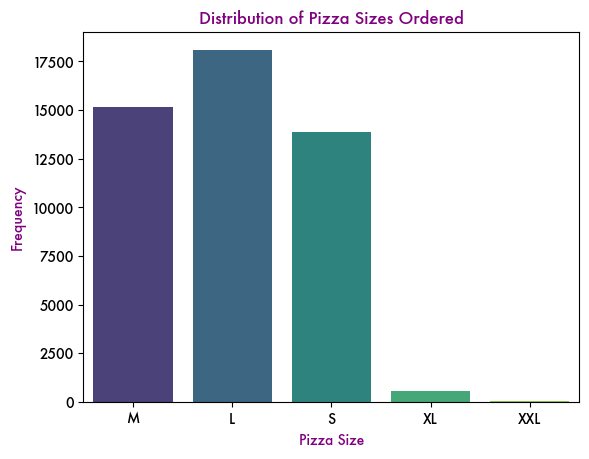

/var/folders/m5/kn9mxdbn7nx7cjrgtfwsk1700000gn/T/ipykernel_50358/3993642337.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['order_date'] = pd.to_datetime(df_filtered['order_date'])
/var/folders/m5/kn9mxdbn7nx7cjrgtfwsk1700000gn/T/ipykernel_50358/3993642337.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['order_day'] = df_filtered['order_date'].dt.day_name()


In [28]:
# creating histogram of distribution of pizza sizes ordered with viridis palette and Futura font
plt.rcParams['font.family'] = 'Futura'
sns.countplot(data=df_filtered, x="pizza_size", palette="viridis")
plt.xlabel("Pizza Size", fontsize=10, color="purple")
plt.ylabel("Frequency", fontsize=10, color="purple")
plt.title("Distribution of Pizza Sizes Ordered", color="purple")
plt.show()

#### Order Frequenct by hour of day

/var/folders/m5/kn9mxdbn7nx7cjrgtfwsk1700000gn/T/ipykernel_50358/2673881995.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['order_hour'] = df_filtered['order_time'].dt.hour
/var/folders/m5/kn9mxdbn7nx7cjrgtfwsk1700000gn/T/ipykernel_50358/2673881995.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='order_hour', data=df_sizes_S_M_L, palette="viridis", ax=axs[0])
/var/folders/m5/kn9mxdbn7nx7cjrgtfwsk1700000gn/T/ipykernel_50358/2673881995.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `h

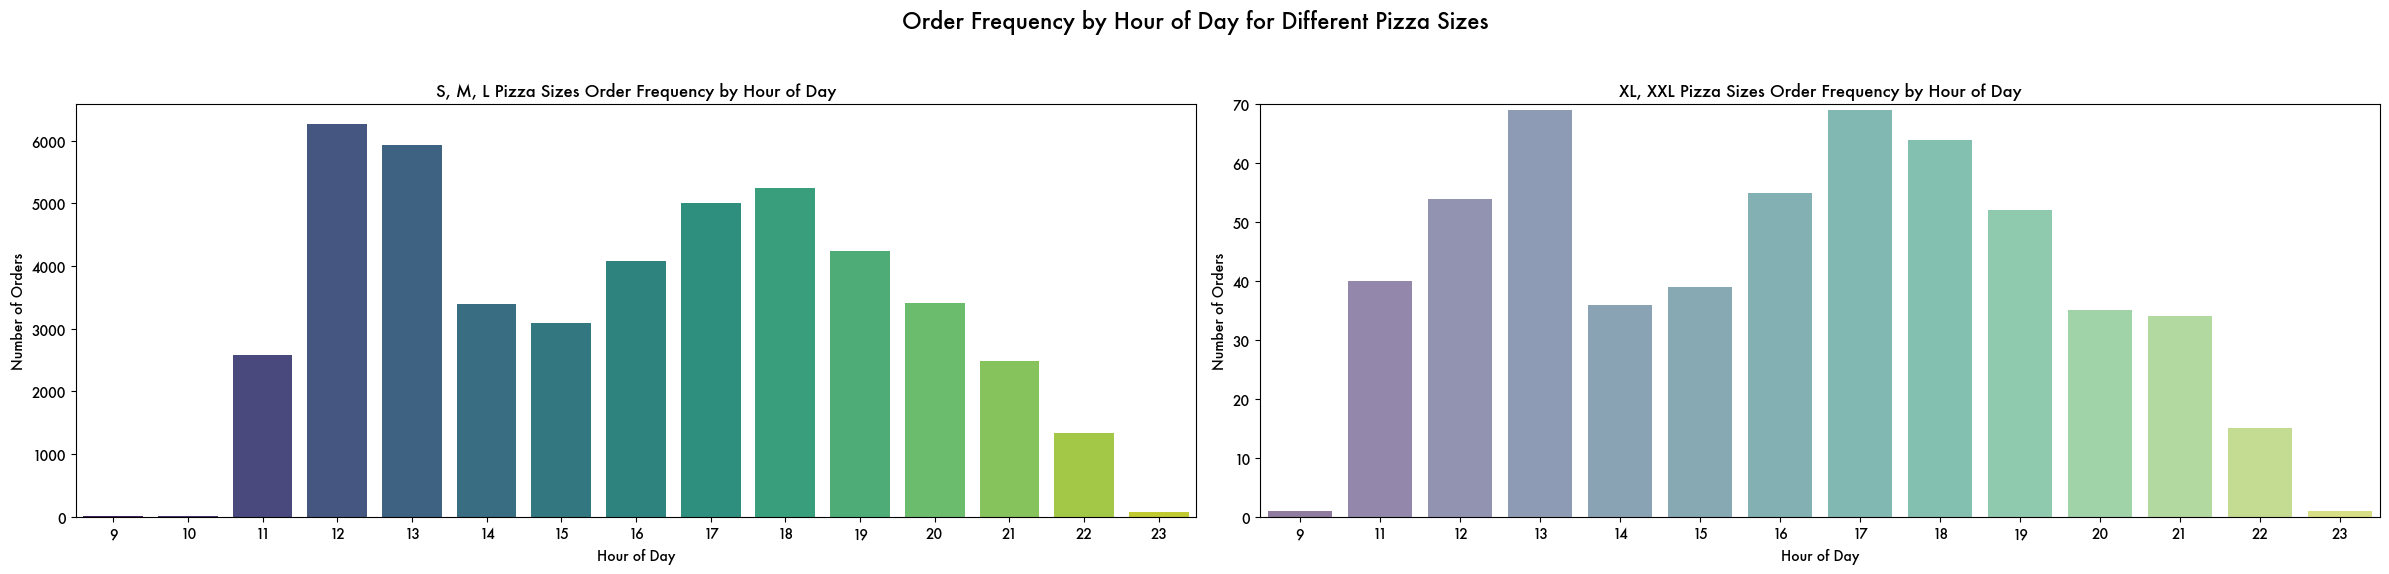

In [29]:
# Setting the global font to Futura
plt.rcParams['font.family'] = 'Futura'

# Creating the 'order_hour' column in the df_filtered before filtering
df_filtered['order_hour'] = df_filtered['order_time'].dt.hour

# Filtering the dataframes again to ensure they contain the 'order_hour' column
df_sizes_S_M_L = df_filtered[df_filtered['pizza_size'].isin(['S', 'M', 'L'])]
df_sizes_XL_XXL = df_filtered[df_filtered['pizza_size'].isin(['XL', 'XXL'])]

# Setting up the figure and axes for subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

# Plotting for S, M, L sizes
sns.countplot(x='order_hour', data=df_sizes_S_M_L, palette="viridis", ax=axs[0])
axs[0].set_title('S, M, L Pizza Sizes Order Frequency by Hour of Day')
axs[0].set_xlabel('Hour of Day')
axs[0].set_ylabel('Number of Orders')

# Plotting for XL, XXL sizes with contrasting color
sns.countplot(x='order_hour', data=df_sizes_XL_XXL, palette="viridis", ax=axs[1], alpha=0.6)
axs[1].set_title('XL, XXL Pizza Sizes Order Frequency by Hour of Day')
axs[1].set_xlabel('Hour of Day')
axs[1].set_ylabel('Number of Orders')

# Zooming in for the XL and XXL sizes plot by adjusting its y-axis limit
max_count_XL_XXL = df_sizes_XL_XXL['order_hour'].value_counts().max()
axs[1].set_ylim(0, max_count_XL_XXL + 1)  # Add some padding to ensure visibility

plt.suptitle('Order Frequency by Hour of Day for Different Pizza Sizes', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to include the suptitle
plt.show()


#### Order Frequency by day of the week

/var/folders/m5/kn9mxdbn7nx7cjrgtfwsk1700000gn/T/ipykernel_50358/403453980.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['order_day'] = df_filtered['order_date'].dt.day_name()
/var/folders/m5/kn9mxdbn7nx7cjrgtfwsk1700000gn/T/ipykernel_50358/403453980.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='order_day', data=df_sizes_S_M_L, order=days_order, palette="viridis", ax=axs[0])
/var/folders/m5/kn9mxdbn7nx7cjrgtfwsk1700000gn/T/ipykernel_50358/403453980.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the

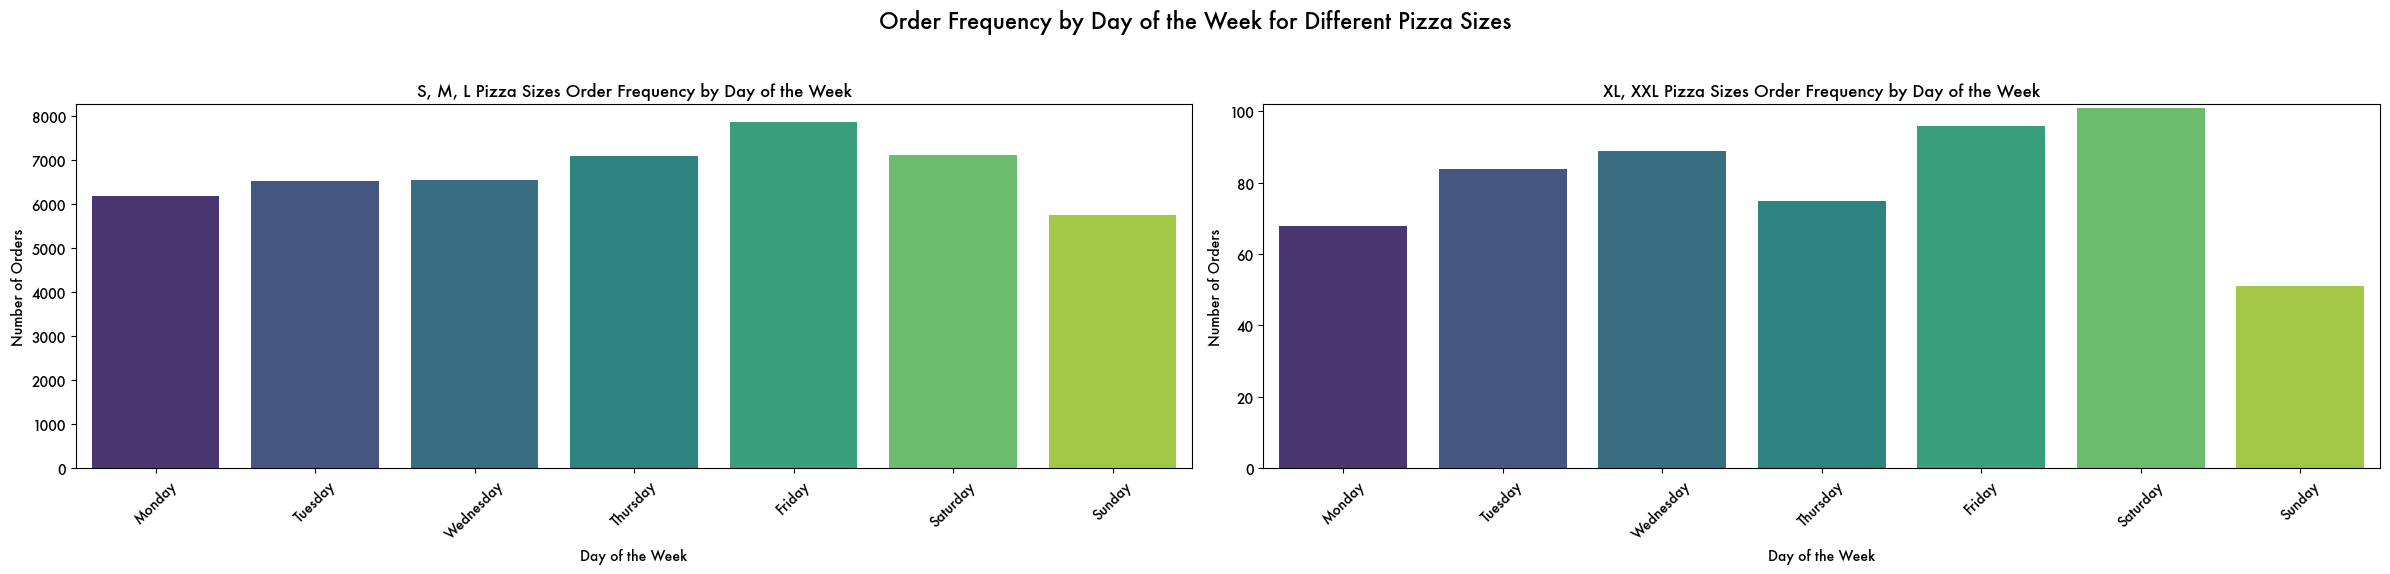

In [30]:
# Ensuring 'order_day' column is properly set up
df_filtered['order_day'] = df_filtered['order_date'].dt.day_name()

# Ordering Days of the week 
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plotting for S, M, L sizes with day of the week distribution
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(24, 6), sharey=False)
plt.rcParams['font.family'] = 'Futura'
sns.countplot(x='order_day', data=df_sizes_S_M_L, order=days_order, palette="viridis", ax=axs[0])
axs[0].set_title('S, M, L Pizza Sizes Order Frequency by Day of the Week')
axs[0].set_xlabel('Day of the Week')
axs[0].set_ylabel('Number of Orders')
axs[0].tick_params(axis='x', rotation=45)

# Plotting for XL, XXL sizes with day of the week distribution and specific zoom in
sns.countplot(x='order_day', data=df_sizes_XL_XXL, order=days_order, palette="viridis", ax=axs[1])
# Determining the max count for XL, XXL sizes to adjust the y-axis limit for zooming in
max_count_XL_XXL = df_sizes_XL_XXL['order_day'].value_counts()[days_order].max()
axs[1].set_ylim(0, max_count_XL_XXL + 1)  # Adjusting y-axis limits for the XL, XXL plot
axs[1].set_title('XL, XXL Pizza Sizes Order Frequency by Day of the Week')
axs[1].set_xlabel('Day of the Week')
axs[1].set_ylabel('Number of Orders')
axs[1].tick_params(axis='x', rotation=45)

plt.suptitle('Order Frequency by Day of the Week for Different Pizza Sizes', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

#### Order Frequency by Month

/var/folders/m5/kn9mxdbn7nx7cjrgtfwsk1700000gn/T/ipykernel_50358/3837565101.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='order_month', data=df_sizes_S_M_L, order=month_names_ordered, palette="viridis", ax=axs[0])
/var/folders/m5/kn9mxdbn7nx7cjrgtfwsk1700000gn/T/ipykernel_50358/3837565101.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='order_month', data=df_sizes_XL_XXL, order=month_names_ordered, palette="viridis", ax=axs[1], alpha=0.6)


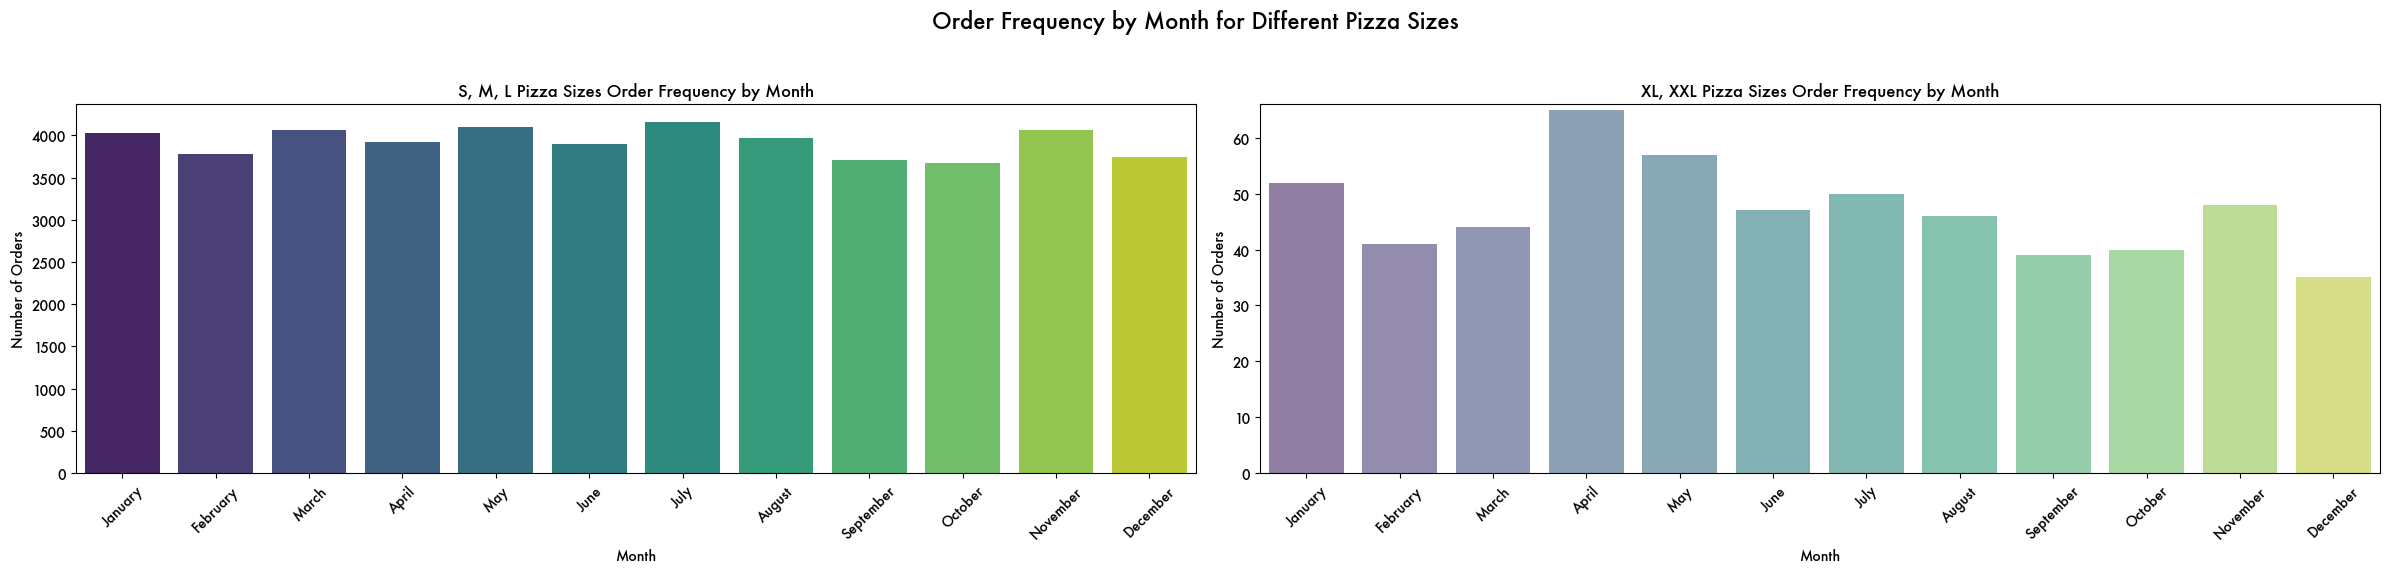

In [31]:
# Ordering Month names for plotting
month_names_ordered = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Plotting for S, M, L sizes with month distribution
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(24, 6), sharey=False)
sns.countplot(x='order_month', data=df_sizes_S_M_L, order=month_names_ordered, palette="viridis", ax=axs[0])
axs[0].set_title('S, M, L Pizza Sizes Order Frequency by Month')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Number of Orders')
axs[0].tick_params(axis='x', rotation=45)

# Plotting for XL, XXL sizes with month distribution
sns.countplot(x='order_month', data=df_sizes_XL_XXL, order=month_names_ordered, palette="viridis", ax=axs[1], alpha=0.6)
# Zooming in for the XL, XXL sizes plot by adjusting its y-axis limit
max_count_XL_XXL = df_sizes_XL_XXL['order_month'].value_counts().max()
axs[1].set_ylim(0, max_count_XL_XXL + 1) 
axs[1].set_title('XL, XXL Pizza Sizes Order Frequency by Month')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Number of Orders')
axs[1].tick_params(axis='x', rotation=45)

plt.suptitle('Order Frequency by Month for Different Pizza Sizes', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()